# Project XOR

William Black

### To run:

1. If the main project directory is `~/my/proj/`, enter ```conda develop ~/my/proj/``` to allow Anaconda to see the project (add it to the PythonPath)

In [1]:
from IPython import display
from importlib_resources import files
from pandas import read_csv
from proj_xor.__main__ import main

2023-02-11 21:05:40.234196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 21:05:40.300724: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-11 21:05:40.643581: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: $LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:/home/william/anaconda3/envs/project_xor/lib/:/home/william/an

## Main Method

You can rerun this `main()` method to retrain the model.

In [2]:
main()

2023-02-11 21:05:41.339950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 21:05:41.356100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 21:05:41.356228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 21:05:41.357774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

  0%|          | 0/60 [00:00<?, ?it/s]

2023-02-11 21:05:42.549707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-11 21:05:42.551242: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f0104140400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-11 21:05:42.551254: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-02-11 21:05:42.555511: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-11 21:05:42.598805: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-11 21:05:42.627389: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is log

Epoch   0	Train Loss: 0.79501486	Train Accuracy: 31.09999847	Test Loss: 0.73844582	Test Accuracy: 50.00000000
Epoch   5	Train Loss: 0.60554403	Train Accuracy: 87.40000153	Test Loss: 0.54373419	Test Accuracy: 91.00000000
Epoch  10	Train Loss: 0.24512517	Train Accuracy: 95.00000000	Test Loss: 0.19239683	Test Accuracy: 97.00000000
Epoch  15	Train Loss: 0.08393446	Train Accuracy: 98.65000153	Test Loss: 0.06395335	Test Accuracy: 99.50000000
Epoch  20	Train Loss: 0.02985161	Train Accuracy: 99.80000305	Test Loss: 0.02357545	Test Accuracy: 100.00000000
Epoch  25	Train Loss: 0.01227301	Train Accuracy: 99.94999695	Test Loss: 0.01002558	Test Accuracy: 100.00000000
Epoch  30	Train Loss: 0.00614993	Train Accuracy: 99.94999695	Test Loss: 0.00506396	Test Accuracy: 100.00000000
Epoch  35	Train Loss: 0.00369527	Train Accuracy: 99.94999695	Test Loss: 0.00304176	Test Accuracy: 100.00000000
Epoch  40	Train Loss: 0.00255123	Train Accuracy: 100.00000000	Test Loss: 0.00211182	Test Accuracy: 100.00000000
Epoc

Below is the code for `main()`

In [3]:
display.Code(files("proj_xor").joinpath("__main__.py"))

import logging
from proj_xor.models import ProjXORWrapper
from proj_xor.plots import plot_data

def main(logging_level=logging.WARNING):
    logging.basicConfig(level=logging_level)
    logging.info("Entering main method.")

    M = ProjXORWrapper()

    M.fit(
        save_plots=True,
        show_plots=False,
        save_dfs=True,
        show_dfs=False,
        monitor_freq=5,
    )

    plot_data.plot_model_performance(M.get_model(), show_plt=False)

    logging.info("Exiting main method.")


if __name__ == "__main__":
    main(logging_level=logging.INFO)

## The Model

Below is the code that makes up the model as well as a wrapper class for convenience

In [4]:
display.Code(files("proj_xor").joinpath("models.py"))

import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

from tensorflow.keras.losses import BinaryCrossentropy as BinaryCrossentropyLoss
from tensorflow.keras.metrics import (
    BinaryCrossentropy as BinaryCrossentropyMetric,
    BinaryAccuracy,
)
from tensorflow.keras.optimizers.experimental import Nadam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.math import argmax
from numpy import uint8
import pandas as pd
from importlib_resources import files

from tqdm.auto import trange, tqdm

from proj_xor.data import get_data
from proj_xor.plots.plot_metrics import plot_loss, plot_accuracy


class ProjXORModel(Model):
    def __init__(
        self,
        loss=None,
        optimizer=None,
        optimizer_schedule=None,
        train_loss_metric=None,
        test_loss_metric=None,
        train_acc_metric=None,
        test_acc_metric=None,
        layers=None,
    ):
        super(ProjXORModel, self).__init__()

        if layers is None:
            self._layers = [
                Dense(2, activation="swish"),
                Dense(1, activation="sigmoid"),
            ]
        else:
            self._layers = layers

        if loss is None:
            self.loss_object = BinaryCrossentropyLoss(from_logits=False)
        else:
            self.loss_object = loss

        if optimizer_schedule is None:
            self._optimizer_schedule = ExponentialDecay(
                2,
                decay_steps=10 ** 2,
                decay_rate=0.8,
                name="exponential_decay_schedule",
            )
        else:
            self._optimizer_schedule = optimizer_schedule
        if optimizer is None:
            self._optimizer = Nadam(
                learning_rate=self._optimizer_schedule,
                name="nadam_optimizer",
            )
        else:
            self._optimizer = optimizer

        if train_loss_metric is None:
            self.train_loss = BinaryCrossentropyMetric(name="train_loss")
        else:
            self.train_loss = train_loss_metric
        if train_acc_metric is None:
            self.train_accuracy = BinaryAccuracy(name="train_accuracy")
        else:
            self.train_accuracy = train_acc_metric

        if test_loss_metric is None:
            self.test_loss = BinaryCrossentropyMetric(name="test_loss")
        else:
            self.test_loss = test_loss_metric
        if test_acc_metric is None:
            self.test_accuracy = BinaryAccuracy(name="test_accuracy")
        else:
            self.test_accuracy = test_acc_metric

    def call(self, x):
        for f in self._layers:
            x = f(x)
        return x


class ProjXORWrapper:
    def __init__(
        self,
        loss=None,
        optimizer=None,
        optimizer_schedule=None,
        train_loss_metric=None,
        test_loss_metric=None,
        train_acc_metric=None,
        test_acc_metric=None,
        layers=None,
        epochs=60,
        batch_size=50,
    ):
        ## I know this function has a lot of repeated code, but fixing it is not a priority
        self._is_fitted = False

        self._epochs = epochs
        self._batch_size = batch_size

        if layers is None:
            self._layers = [
                Dense(2, activation="swish"),
                # swish works much better than relu or sigmoid
                Dense(1, activation="sigmoid"),
            ]
        else:
            self._layers = layers

        if loss is None:
            self.loss_object = BinaryCrossentropyLoss(from_logits=False)
        else:
            self.loss_object = loss

        if optimizer_schedule is None:
            self._optimizer_schedule = ExponentialDecay(
                0.5,
                decay_steps=10 ** 2,
                decay_rate=0.9,
                name="exponential_decay_schedule",
            )
        else:
            self._optimizer_schedule = optimizer_schedule
     

## Loss and Accuracy

### Loss

Below is the plot of the loss as well as the associated table of data.

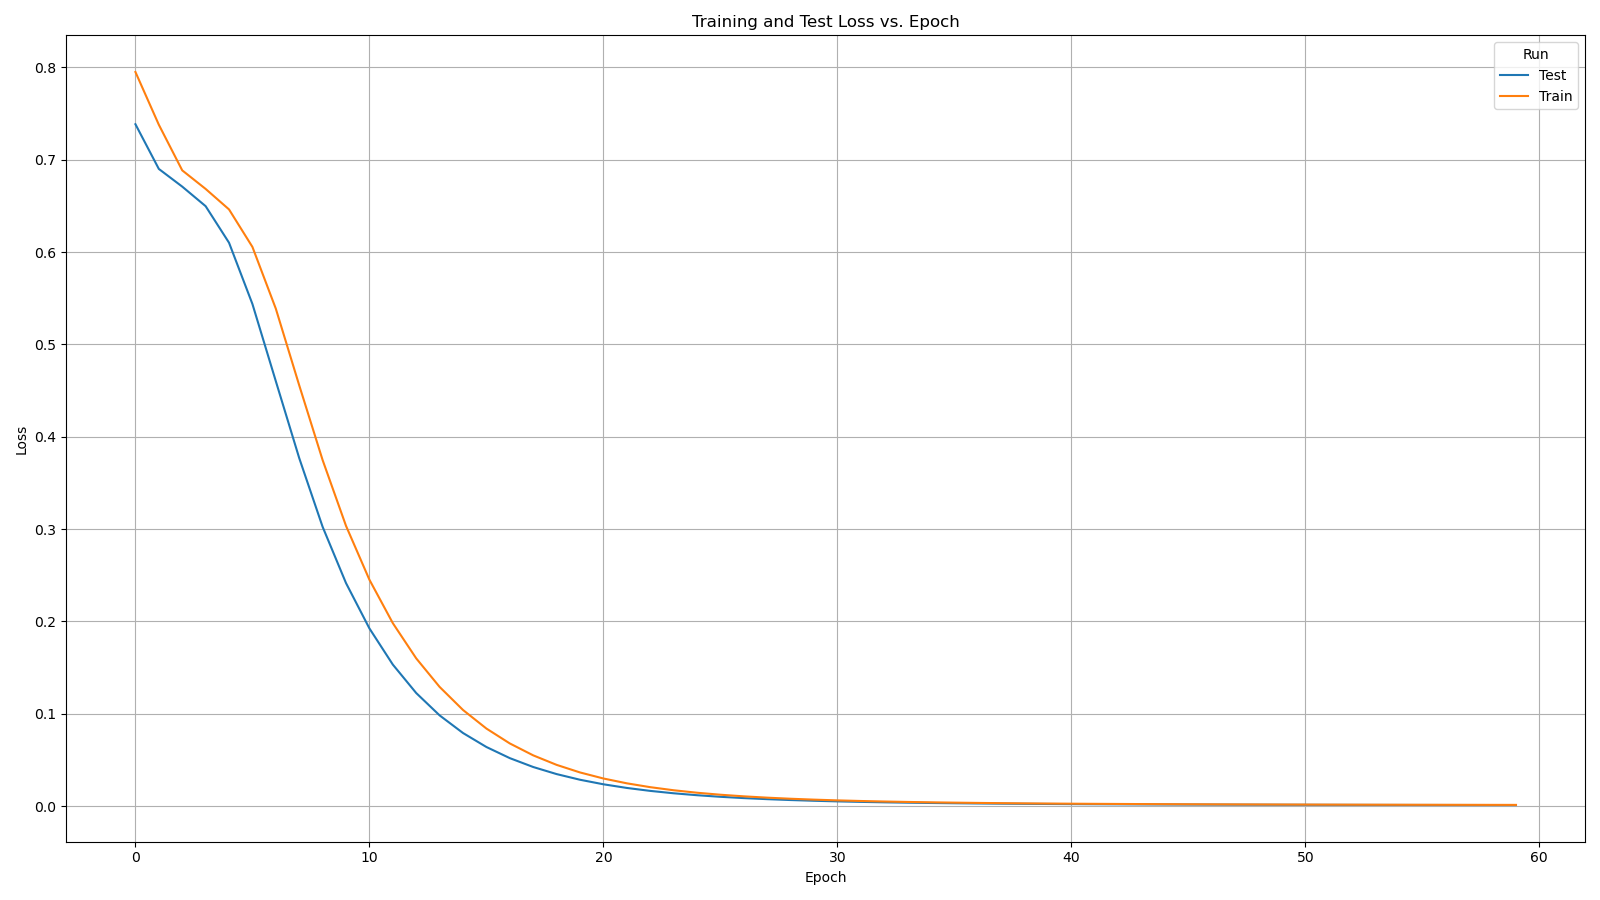

In [5]:
display.Image(files("proj_xor.plots.metrics").joinpath("loss.png"))

In [6]:
display.display(read_csv(files("proj_xor.data.outputs").joinpath("loss.csv")))

,epoch,run,val
0,0,test,0.738446
1,1,test,0.690026
2,2,test,0.670873
3,3,test,0.649693
4,4,test,0.610101
...,...,...,...
115,55,train,0.001379
116,56,train,0.001345
117,57,train,0.001313
118,58,train,0.001284


### Accuracy

Below is the plot of the accuracy as well as the associated table of data.

In [7]:
display.display(read_csv(files("proj_xor.data.outputs").joinpath("accuracy.csv")))

,epoch,run,val
0,0,test,0.500
1,1,test,0.500
2,2,test,0.655
3,3,test,0.845
4,4,test,0.860
...,...,...,...
115,55,train,1.000
116,56,train,1.000
117,57,train,1.000
118,58,train,1.000


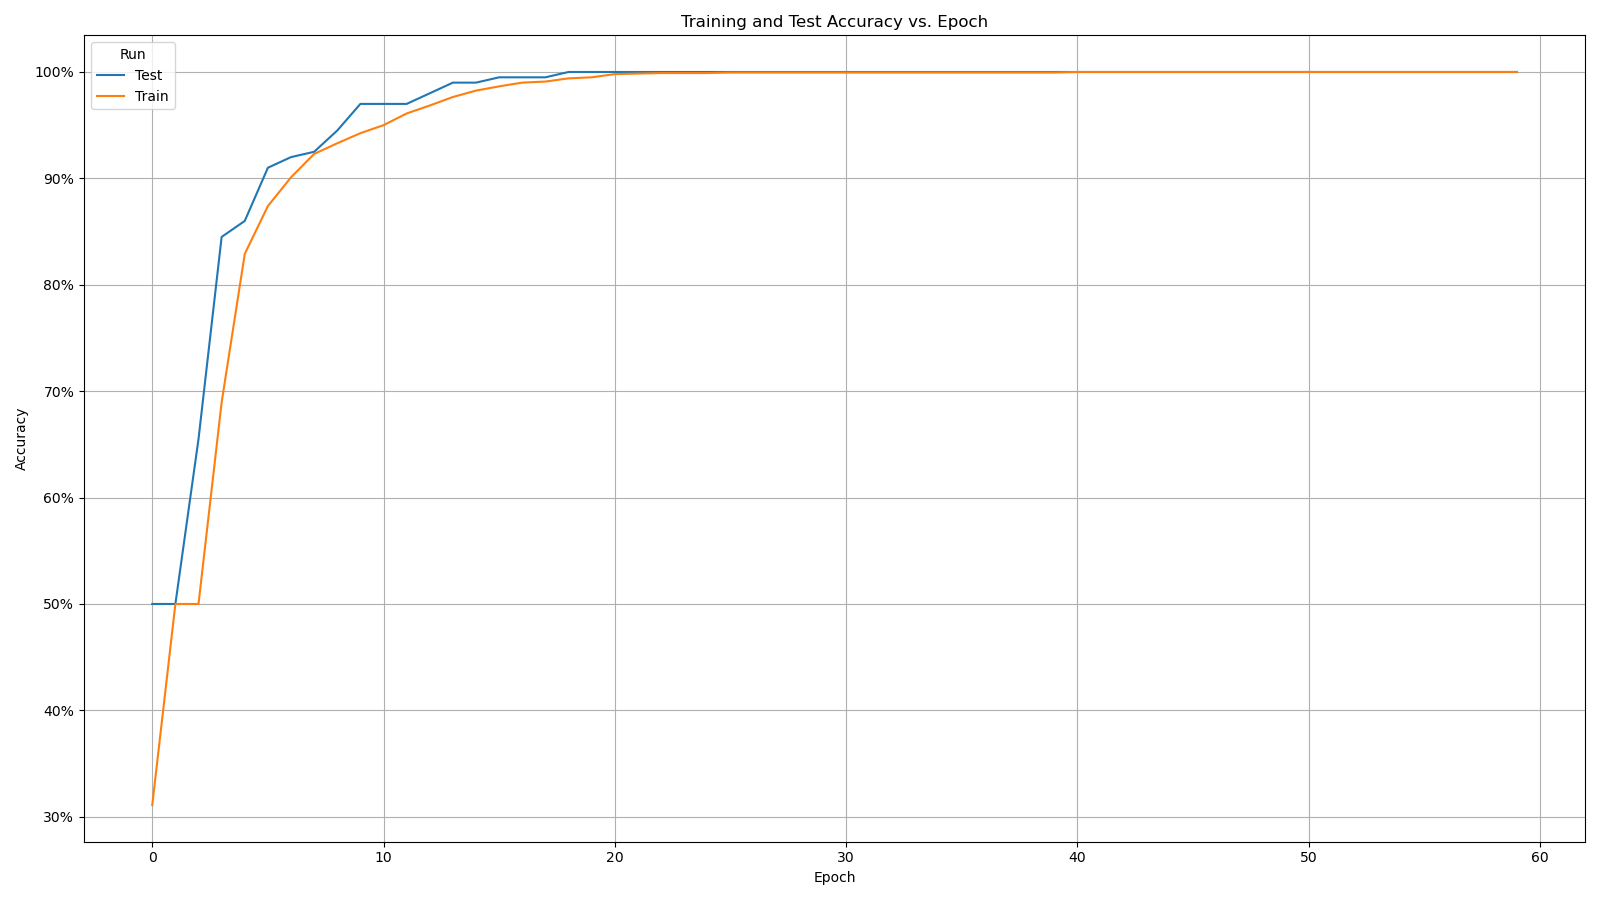

In [8]:
display.Image(files("proj_xor.plots.metrics").joinpath("accuracy.png"))

### Plotting Code

The below code was used to generate the loss and accuracy plots.

In [9]:
display.Code(files("proj_xor.plots").joinpath("plot_metrics.py"))

import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
from importlib_resources import files

_plot_path = files("proj_xor.plots.metrics")


def plot_loss(loss_df, save_plt=True, show_plt=False, fname=None):
    if not (save_plt or show_plt):
        return
    loss_df["run"] = loss_df["run"].replace(["test"], "Test")
    loss_df["run"] = loss_df["run"].replace(["train"], "Train")
    loss_df = loss_df.set_axis(["Epoch", "Run", "Loss"], axis='columns')

    plt.figure(figsize=(16, 9))
    plot = sns.lineplot(
        data=loss_df,
        x="Epoch",
        y="Loss",
        hue="Run",
    )

    plt.title("Training and Test Loss vs. Epoch") 
    plt.grid()
    plt.tight_layout()

    if save_plt:
        if fname is None:
            fname = "loss.png"
        plt.savefig(_plot_path.joinpath(fname))
    if show_plt:
        plt.show()
    plt.close()


def plot_accuracy(acc_df, save_plt=True, show_plt=False, fname=None):
    if not (save_plt or show_plt):
        return
    acc_df["run"] = acc_df["run"].replace(["test"], "Test")
    acc_df["run"] = acc_df["run"].replace(["train"], "Train")
    acc_df = acc_df.set_axis(["Epoch", "Run", "Accuracy"], axis='columns')

    plt.figure(figsize=(16, 9))
    plot = sns.lineplot(
        data=acc_df,
        x="Epoch",
        y="Accuracy",
        hue="Run",
    )
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title("Training and Test Accuracy vs. Epoch")
    plt.grid()
    plt.tight_layout()

    if save_plt:
        if fname is None:
            fname = "accuracy.png"
        plt.savefig(_plot_path.joinpath(fname))
    if show_plt:
        plt.show()
    plt.close()

## Test Performance

Below is a visualization of the model's performance on the test data with the code used to generate it.

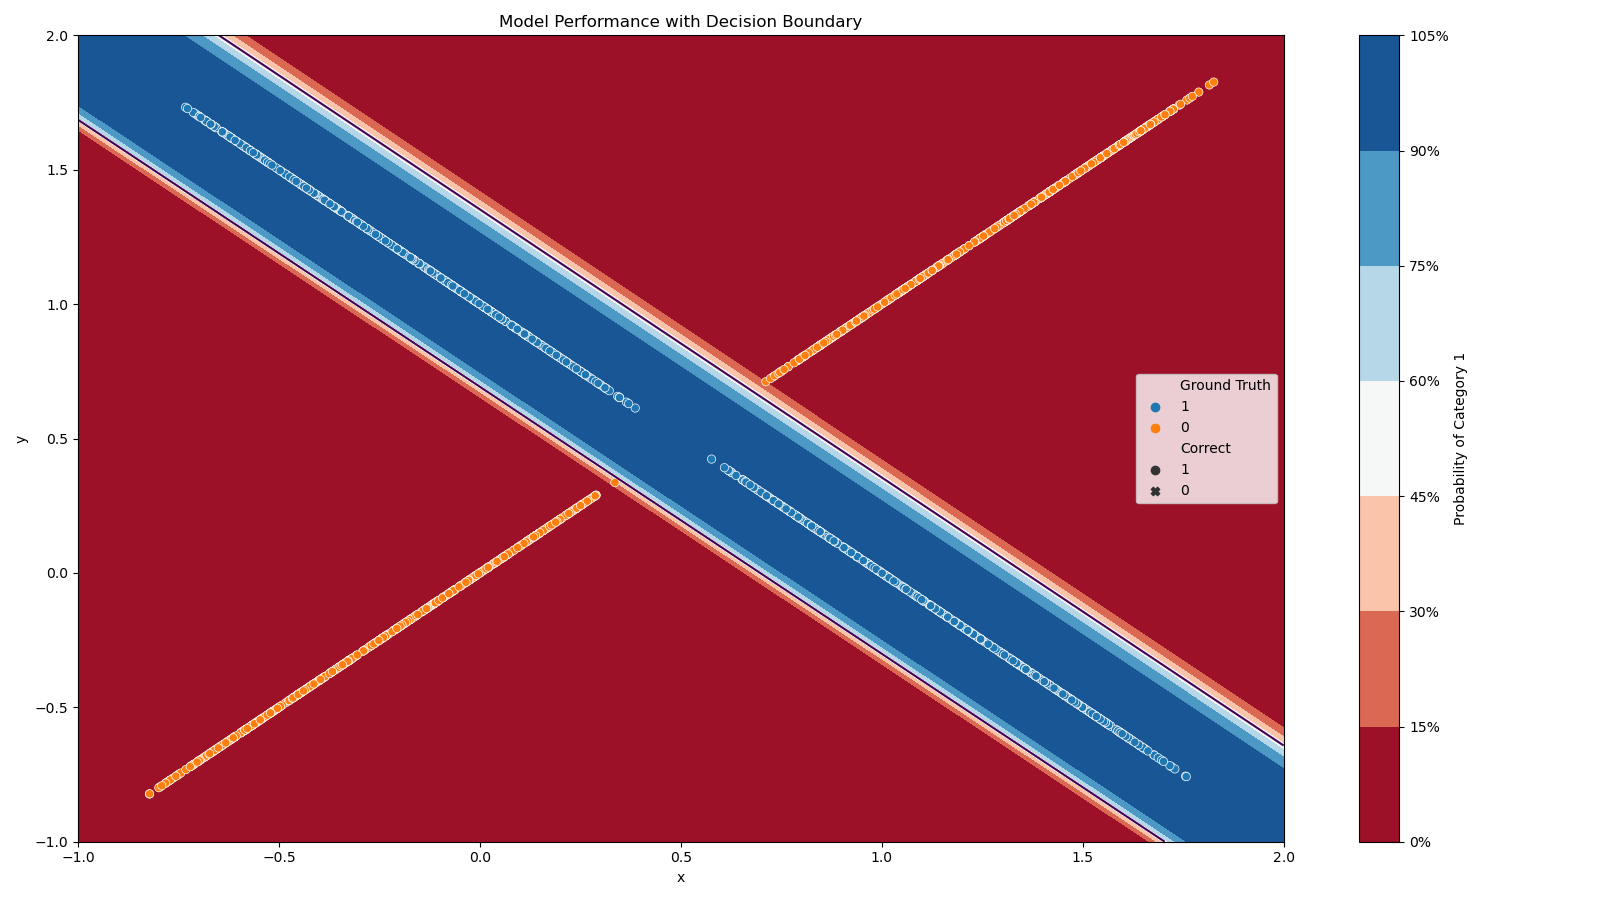

In [10]:
display.Image(files("proj_xor.plots.data").joinpath("performance.png"))

In [11]:
display.Code(files("proj_xor.plots").joinpath("plot_data.py"))

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from importlib_resources import files
import tensorflow as tf
import pandas as pd
import numpy as np
from proj_xor.data import get_data


_plot_path = files("proj_xor.plots.data")
_dataset_path = files("proj_xor.data.datasets")


def plot_model_performance(model, save_plt=True, show_plt=False, fname=None):
    for data, labels in get_data.train_data():
        labels = tf.cast(tf.reshape(labels, (-1, 1)), tf.dtypes.uint8)
        pred = tf.cast(model(data) > 0.5, tf.dtypes.uint8)

    df = pd.DataFrame(
        data={
            "x": data[:, 0],
            "y": data[:, 1],
            "Ground Truth": pd.Series(tf.reshape(labels, (-1,))),
            "Prediction": pd.Series(tf.reshape(pred, (-1,))),
            "Correct": pd.Series(tf.reshape(labels == pred, (-1,)), dtype=int),
        },
    )

    plt.figure(figsize=(16, 9))

    xlim = (-1, 2)
    ylim = (-1, 2)
    N_h_gridpoints = 100 * (xlim[1] - xlim[0])
    N_v_gridpoints = 100 * (ylim[1] - ylim[0])

    hmesh = np.linspace(*xlim, num=N_h_gridpoints)
    vmesh = np.linspace(*ylim, num=N_v_gridpoints)

    xgrid, ygrid = np.meshgrid(hmesh, vmesh)

    onehotx, onehoty = xgrid.reshape((-1, 1)), ygrid.reshape((-1, 1))

    onehotgrid = np.hstack((onehotx, onehoty))

    onehotgridpred = model(onehotgrid)

    gridpred = tf.reshape(onehotgridpred, xgrid.shape)

    cf = plt.contourf(
        xgrid,
        ygrid,
        gridpred,
        cmap="RdBu",
    )
    plt.colorbar(
        cf,
        label="Probability of Category 1",
        spacing="proportional",
        format=PercentFormatter(xmax=1),
    )

    plt.contour(
        xgrid,
        ygrid,
        gridpred,
        levels=[0.5],
    )

    sns.scatterplot(
        data=df,
        x="x",
        y="y",
        hue="Ground Truth",
        hue_order=[1, 0],
        style="Correct",
        style_order=[1, 0],
    )

    plt.title("Model Performance with Decision Boundary")
    plt.legend(loc="center right")
    plt.tight_layout()

    if save_plt:
        if fname is None:
            fname = "performance.png"
        plt.savefig(_plot_path.joinpath(fname))
    if show_plt:
        plt.show()

    plt.close()